In [6]:
#%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import joblib
from flask import Flask, request, jsonify

Loading data

In [7]:
df = pd.read_csv('kidney_dataset.csv')
print("Data loaded",df.shape)

Data loaded (5000, 11)


Data exploration

In [8]:
print("Data info:")
print(df.info())
print('\n Statistics summary:')
print(df.describe(include='all'))

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Creatinine        5000 non-null   float64
 1   BUN               5000 non-null   float64
 2   GFR               5000 non-null   float64
 3   Urine_Output      5000 non-null   float64
 4   Diabetes          5000 non-null   int64  
 5   Hypertension      5000 non-null   int64  
 6   Age               5000 non-null   float64
 7   Protein_in_Urine  5000 non-null   float64
 8   Water_Intake      5000 non-null   float64
 9   Medication        2013 non-null   object 
 10  CKD_Status        5000 non-null   int64  
dtypes: float64(7), int64(3), object(1)
memory usage: 429.8+ KB
None

 Statistics summary:
         Creatinine          BUN          GFR  Urine_Output     Diabetes  \
count   5000.000000  5000.000000  5000.000000   5000.000000  5000.000000   
unique          NaN         

Data cleaning

In [9]:
#check for dupliate rows
duplicate = df.duplicated()
print("count of duplicates: ", duplicate.sum())
#Column data type
cat_col = [col for col in df.columns if df[col].dtype == 'object']
num_col = [col for col in df.columns if df[col].dtype != 'object']
print("Categorical columns: ", cat_col)
print("Numerical columns: ", num_col)
# unique values in categorical columns
print("unique values in categorical columns:\n" , df[cat_col].nunique())
#Missing values
missing_values = df.isnull().sum()
print("missing values:\n", missing_values)

if missing_values.sum() > 0:
    df = df.dropna()
    print("Detected missing values are dropped")
else:
    print("No missing values are detected")

count of duplicates:  0
Categorical columns:  ['Medication']
Numerical columns:  ['Creatinine', 'BUN', 'GFR', 'Urine_Output', 'Diabetes', 'Hypertension', 'Age', 'Protein_in_Urine', 'Water_Intake', 'CKD_Status']
unique values in categorical columns:
 Medication    3
dtype: int64
missing values:
 Creatinine             0
BUN                    0
GFR                    0
Urine_Output           0
Diabetes               0
Hypertension           0
Age                    0
Protein_in_Urine       0
Water_Intake           0
Medication          2987
CKD_Status             0
dtype: int64
Detected missing values are dropped


In [11]:
%matplotlib inline

Data preprocessing

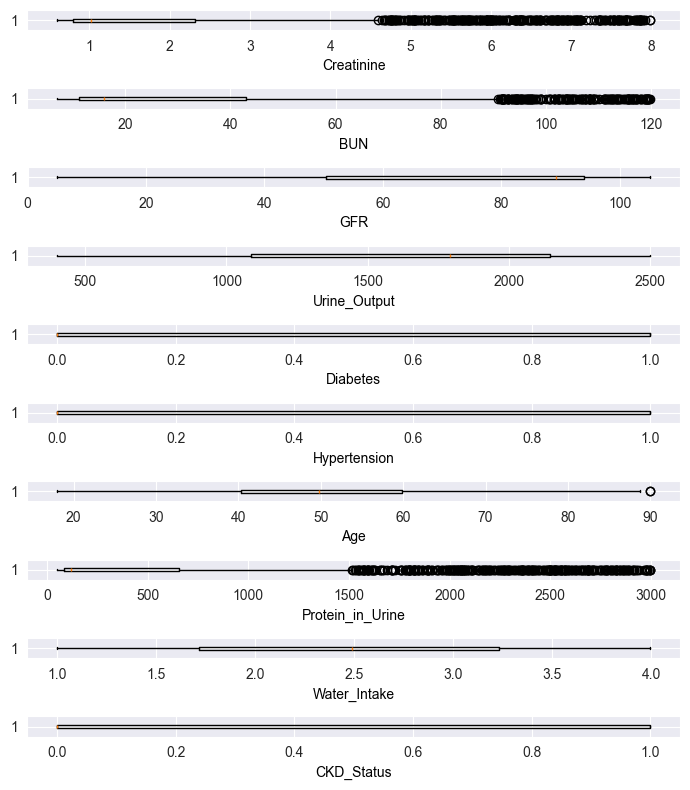

In [14]:
#boxplot for outliers
fig, axs = plt.subplots(len(num_col), 1, figsize = (7,8), dpi = 100)
fig.patch.set_facecolor('white')
if len(num_col) == 1:
    axs = [axs]
for i, col in enumerate(num_col):
    data = df[col].dropna().to_numpy()
    axs[i].boxplot([data], vert = False, showfliers = True)
    axs[i].set_xlabel(col, color = 'black')
plt.tight_layout()
plt.show()

In [15]:
#removing outliers using IQR method
cols = num_col
Q1 = df[cols].quantile(0.25)
Q3 = df[cols].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR
mask = ~((df[cols]<lower) | (df[cols]> upper)).any(axis = 1)
df_no_outliers = df[mask]
df = df_no_outliers

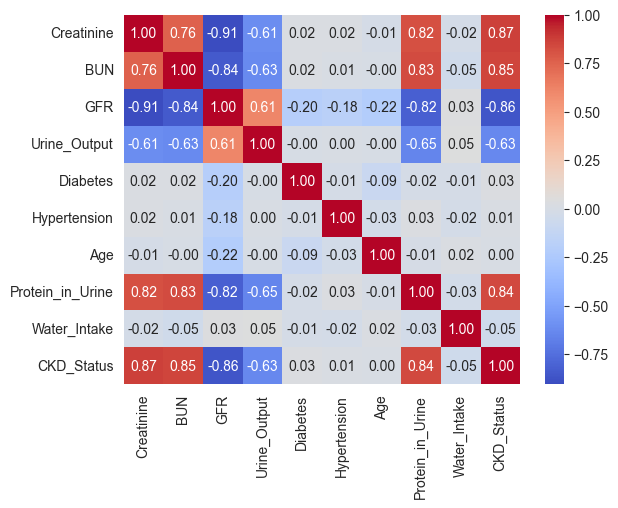

In [16]:
#correlation analysis
corr = df[num_col].corr()
plt.figure(dpi = 100)
sns.heatmap(corr, annot=True, fmt = '.2f',cmap = 'coolwarm')
plt.show()

Exploratory data analysis

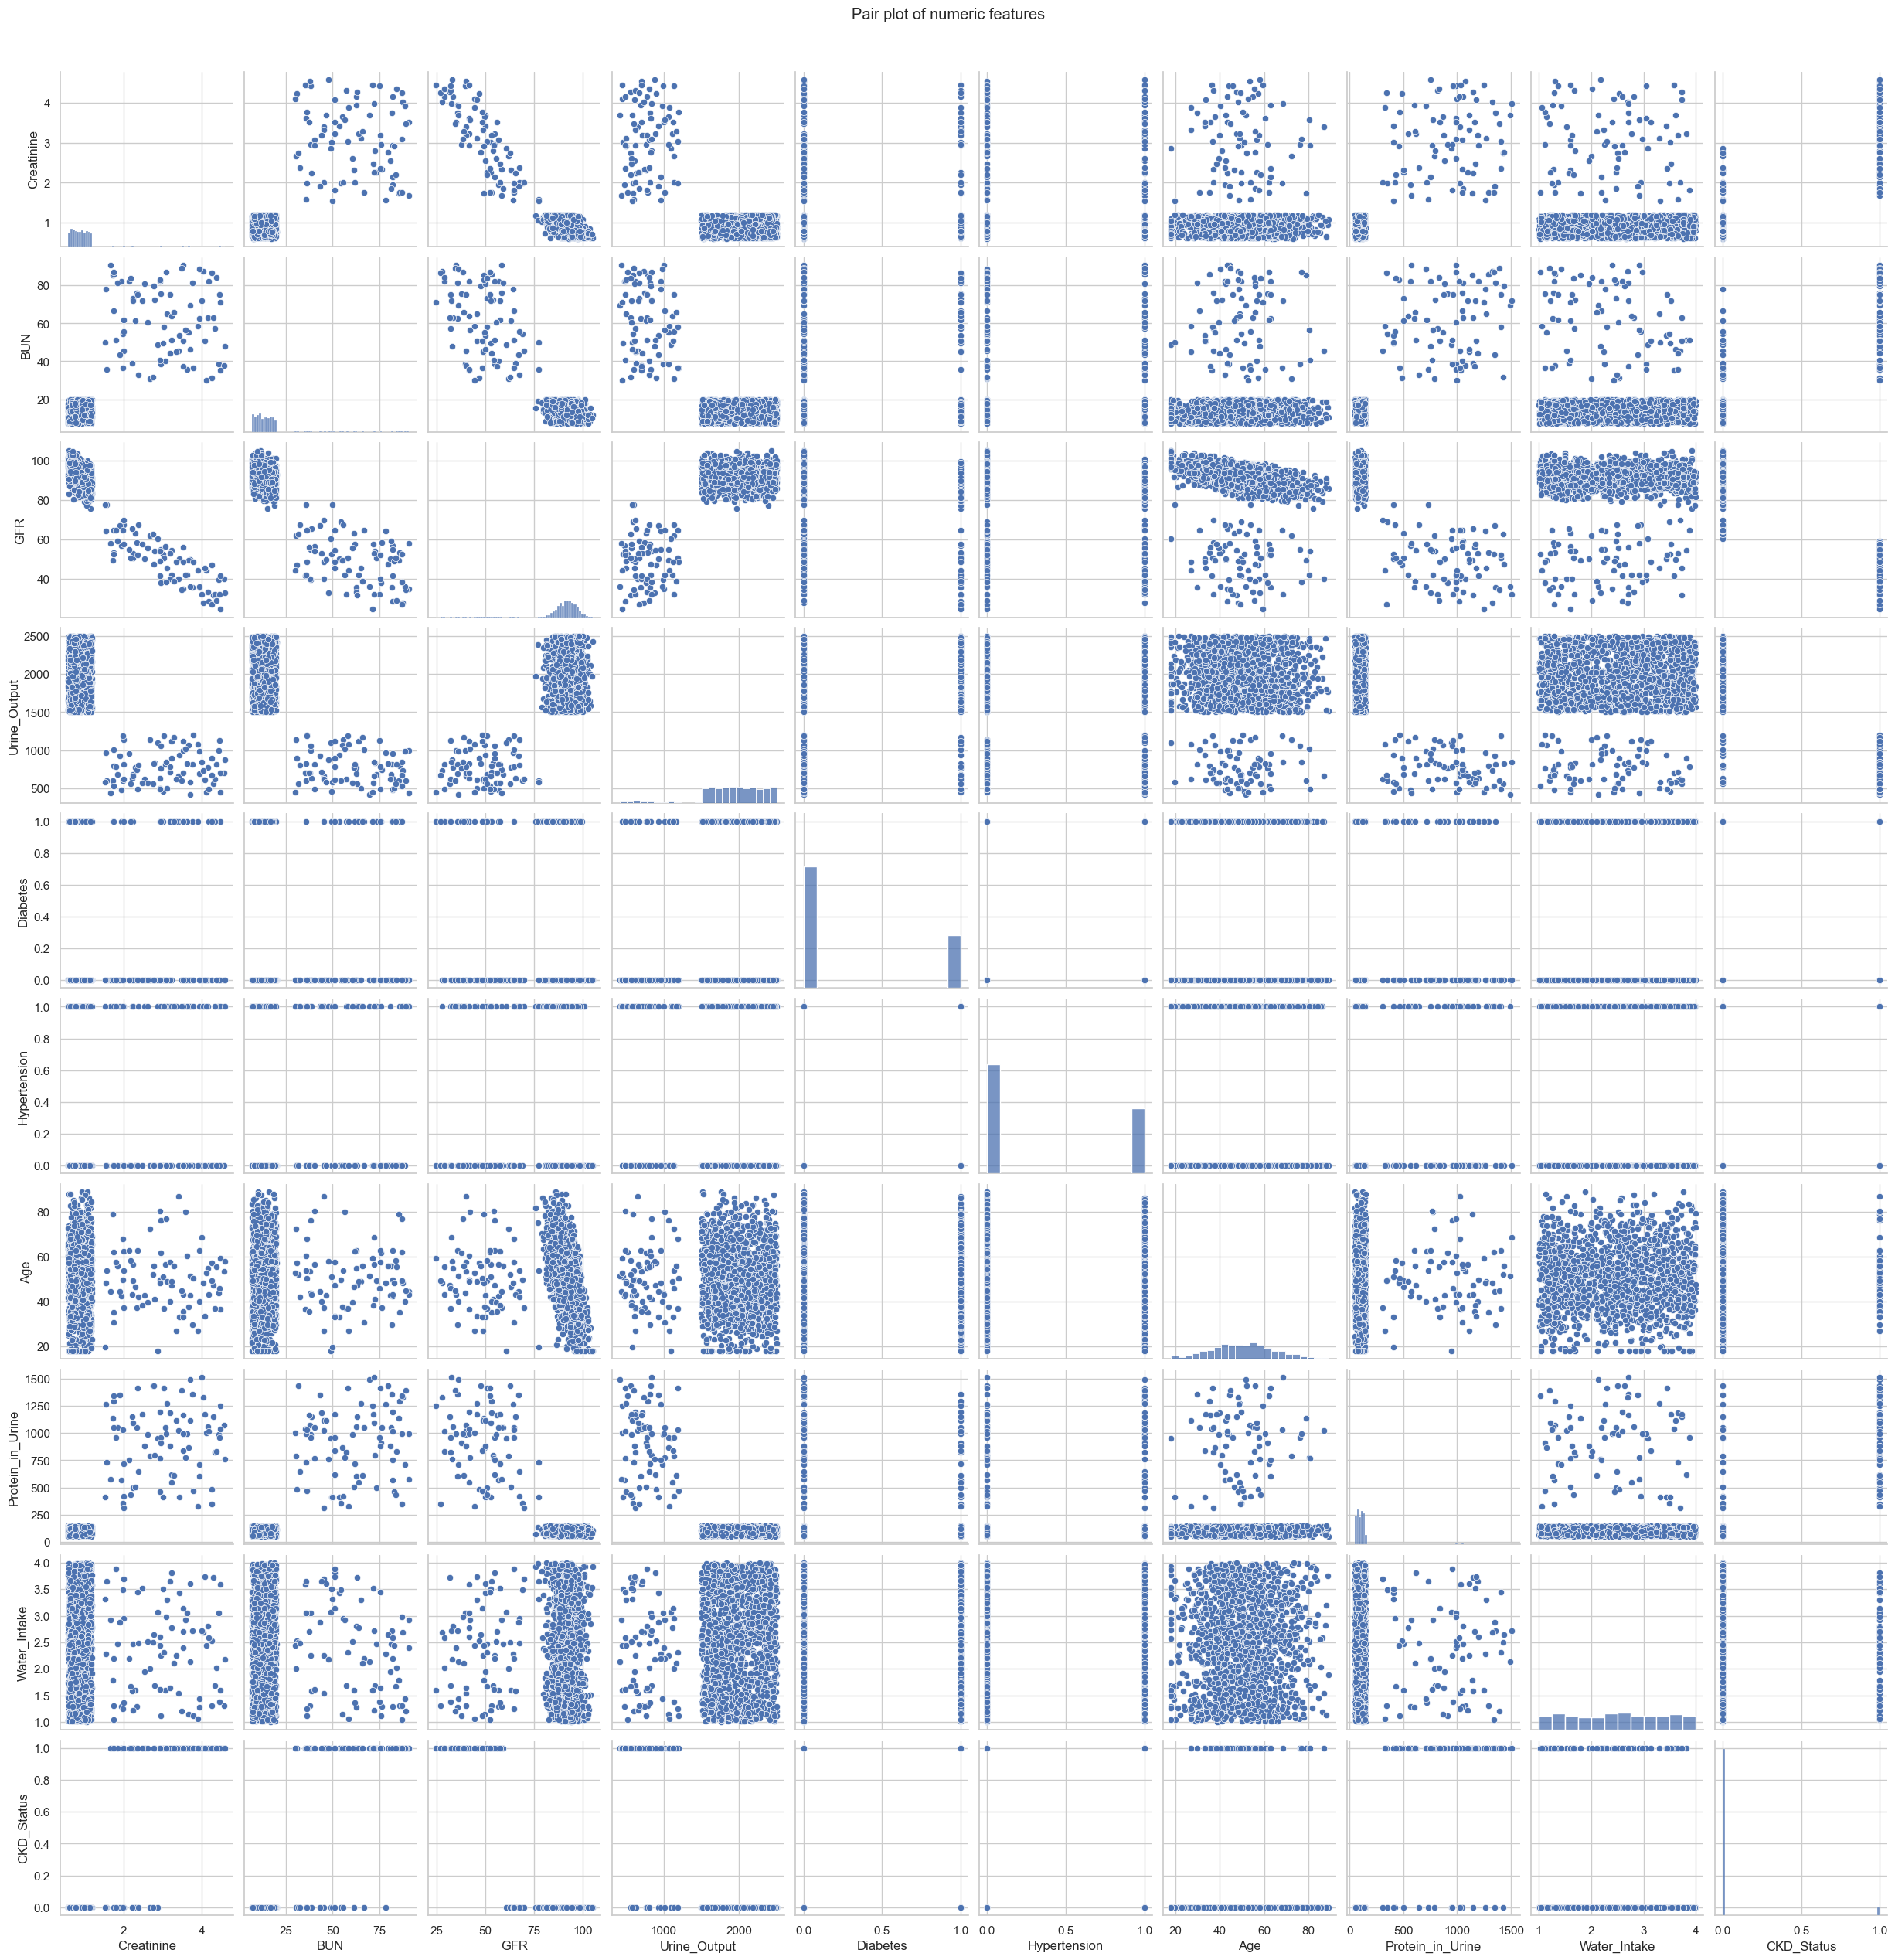

In [17]:
#Visualizations
sns.set(style = 'whitegrid')

#pair plot for numeric features
if len(num_col) >= 2:
    sns.pairplot(df[num_col])
    plt.suptitle("Pair plot of numeric features", y = 1.02)
    plt.show()

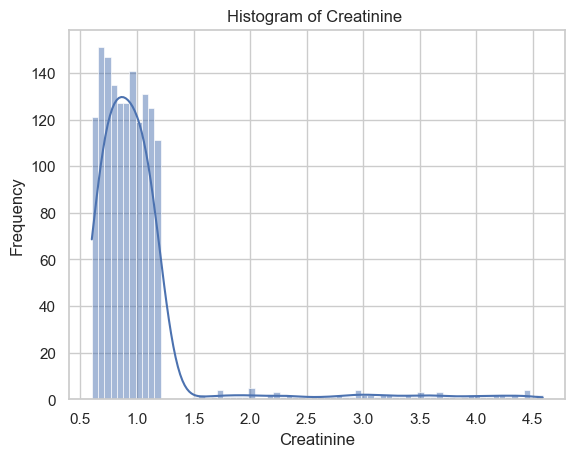

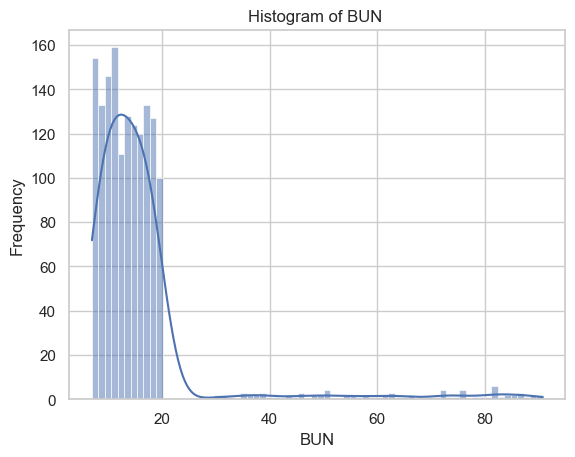

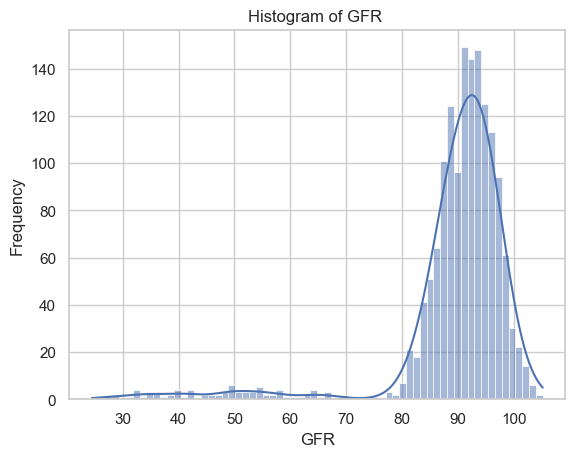

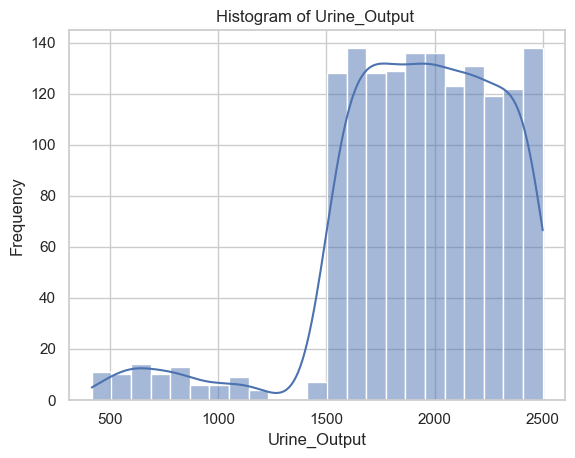

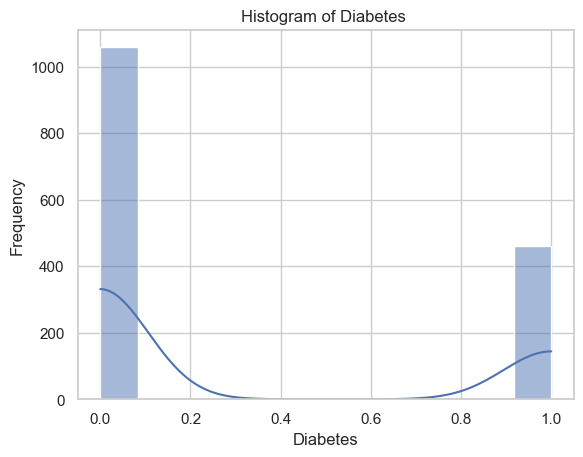

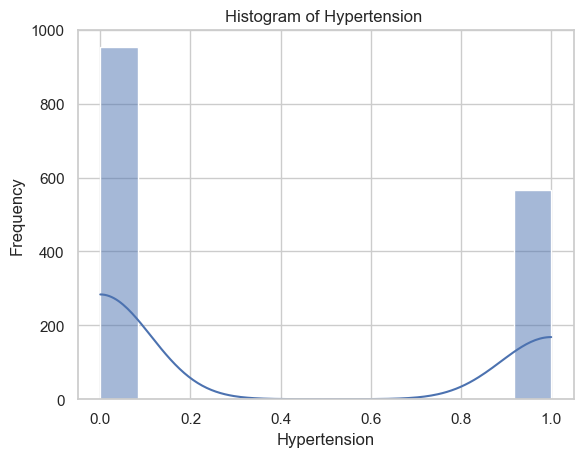

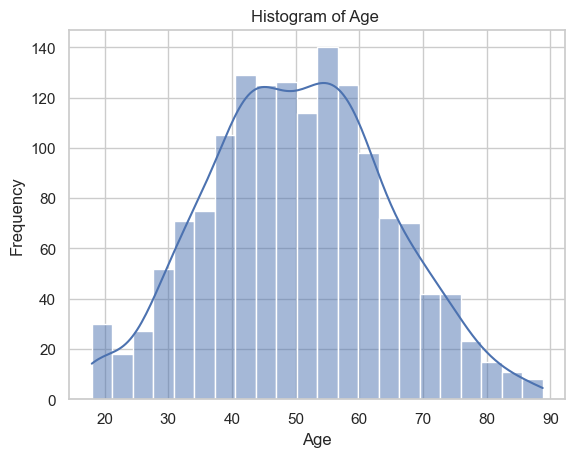

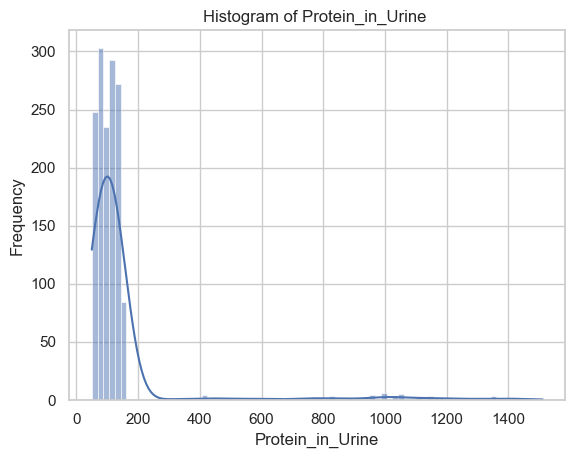

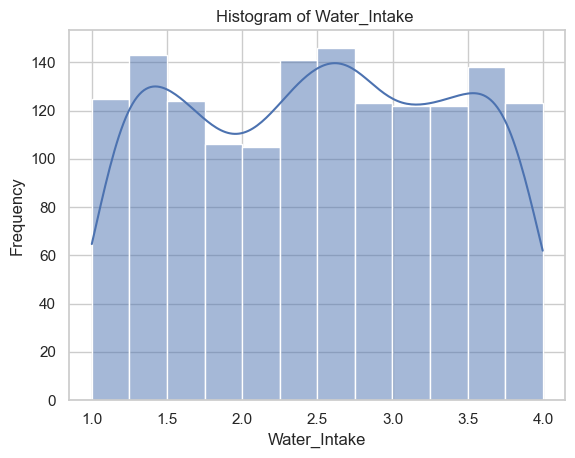

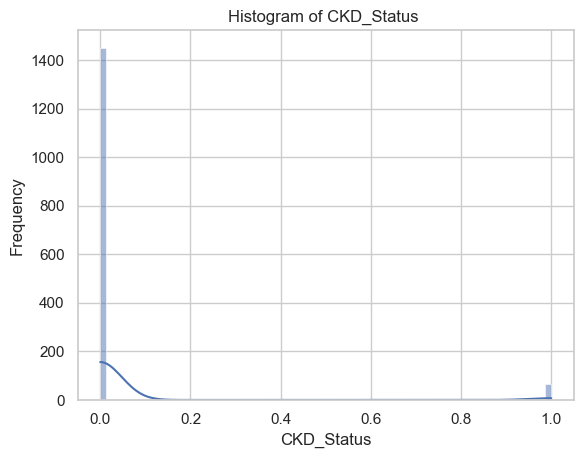

In [19]:
sns.set(style = 'whitegrid')
#histograms for individual numeric fetaures
for col in num_col:
    plt.figure()
    sns.histplot(df[col],kde = True)
    plt.title(f"Histogram of {col} ")
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

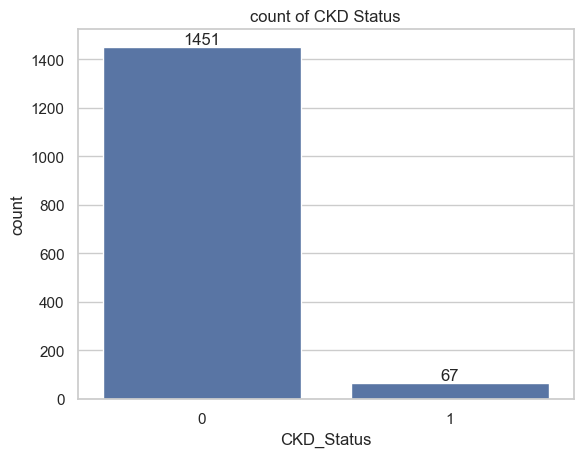

In [20]:
#count plot of ckd status
sns.set(style = 'whitegrid')
plt.figure()
ax = sns.countplot(x = 'CKD_Status', data = df)
for container in ax.containers:
    ax.bar_label(container)
plt.title('count of CKD Status')
plt.show()

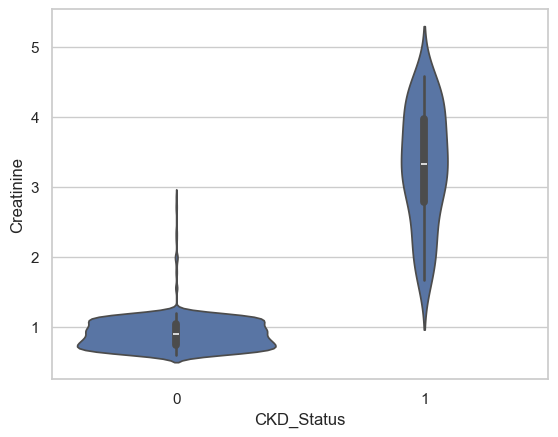

In [21]:
#violin plot for creatinine and ckd status
sns.violinplot(x = 'CKD_Status', y = 'Creatinine', data = df, inner = 'box')
plt.show()

Feature selection using correlation matrix

In [22]:
correlation_matrix = df[num_col].corr()
target_corr = correlation_matrix['CKD_Status'].abs()
high_corr_features = target_corr[target_corr > 0.1 ].index
print("high correlation features:", high_corr_features)

high correlation features: Index(['Creatinine', 'BUN', 'GFR', 'Urine_Output', 'Protein_in_Urine',
       'CKD_Status'],
      dtype='object')


In [23]:
x = df[high_corr_features]
y = df['CKD_Status']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
model = RandomForestClassifier(
    n_estimators = 100,
    max_depth = 10,
    min_samples_split = 2,
    min_samples_leaf = 1,
    random_state = 42
)
model.fit(x_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Splitting data and model initialization

Model evaluation

In [24]:
y_pred = model.predict(x_test)
#calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)
print("ROC AUC:", roc_auc)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 score: 1.0
ROC AUC: 1.0


Model interpretation

            Feature  Importance
5        CKD_Status    0.334618
2               GFR    0.268262
0        Creatinine    0.185256
1               BUN    0.103221
3      Urine_Output    0.091726
4  Protein_in_Urine    0.016917


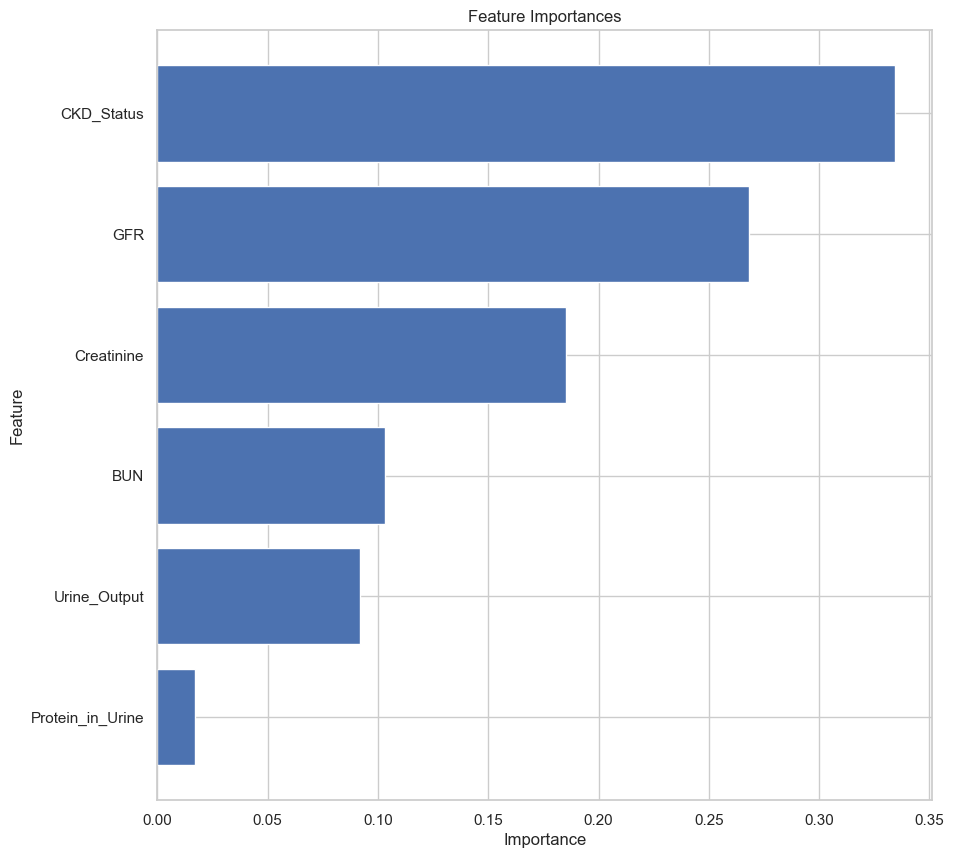

In [25]:
feature_importance = model.feature_importances_
feature_names = x_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending = False)
print(importance_df)
plt.figure(figsize = (10,10))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()